# Project Overview
Objective: Predict the After Tax Return on Equity (ROE) of companies based on financial metrics.
Data: Historical financial data of companies listed on the NYSE, including various financial metrics.

## Importing Necessary Libraries
We'll start by importing all the essential libraries required for data manipulation, visualization, and modeling.

In [142]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Machine Learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Feature Selection
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression

# Model Explainability
import shap
import lime
from lime import lime_tabular

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set plot aesthetics
sns.set_theme(style="whitegrid", palette="muted")
%matplotlib inline

## Loading and Inspecting the Data
We'll load the dataset, inspect the first few rows, check for missing values, and understand the data types.

In [143]:
# Load the dataset
df = pd.read_csv('../data/raw/fundamentals.csv', index_col=0)

# Display the first few rows to inspect the data
print("First five rows of the dataset:")
df.head()

First five rows of the dataset:


,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,AAL,2012-12-31,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,...,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,2012.0,-5.60,3.350000e+08
1,AAL,2013-12-31,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,...,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,2013.0,-11.25,1.630222e+08
2,AAL,2014-12-31,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,...,1.175000e+10,1.340400e+10,2.021000e+09,4.120400e+10,4.322500e+10,4.265000e+10,0.0,2014.0,4.02,7.169154e+08
3,AAL,2015-12-31,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,1.085000e+09,...,9.985000e+09,1.360500e+10,5.635000e+09,4.278000e+10,4.841500e+10,4.099000e+10,0.0,2015.0,11.39,6.681299e+08
4,AAP,2012-12-29,2.409453e+09,-89482000.0,6.000000e+05,32.0,-2.711820e+08,5.202150e+08,23.0,5.981110e+08,...,3.184200e+09,2.559638e+09,1.210694e+09,3.403120e+09,4.613814e+09,6.205003e+09,-27095000.0,2012.0,5.29,7.328355e+07


In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1781 entries, 0 to 1780
Data columns (total 78 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Ticker Symbol                                        1781 non-null   object 
 1   Period Ending                                        1781 non-null   object 
 2   Accounts Payable                                     1781 non-null   float64
 3   Accounts Receivable                                  1781 non-null   float64
 4   Add'l income/expense items                           1781 non-null   float64
 5   After Tax ROE                                        1781 non-null   float64
 6   Capital Expenditures                                 1781 non-null   float64
 7   Capital Surplus                                      1781 non-null   float64
 8   Cash Ratio                                           1482 non-null   floa

In [145]:
# Convert 'Period Ending' to datetime
df['Period Ending'] = pd.to_datetime(df['Period Ending'])

# Sort the dataframe by 'Ticker Symbol' and 'Period Ending'
df = df.sort_values(by=['Ticker Symbol', 'Period Ending'])

pd.crosstab(df['Period Ending'].dt.year, df['For Year'], dropna=False)

For Year,1215.0,2012.0,2013.0,2014.0,2015.0,2016.0,NaN
Period Ending,,,,,,,
2003,0,0,0,0,0,0,1
2004,0,0,0,0,0,0,1
2006,0,0,0,0,0,0,1
2007,0,0,0,0,0,0,1
2012,0,226,0,0,0,0,10
2013,0,18,405,0,0,0,16
2014,0,0,20,400,0,0,16
2015,1,0,0,28,397,0,19
2016,0,0,0,0,28,85,107


In [146]:
df = df.sort_values(by=['Ticker Symbol', 'For Year', 'Period Ending'])
df = df.drop_duplicates(['Ticker Symbol', 'For Year'], keep='last')

In [147]:
df = df.sort_values(by=['Ticker Symbol', 'For Year', 'Period Ending'])

# Drop duplicates, keeping the last instance
df_unique = df.drop_duplicates(subset=['Ticker Symbol', 'For Year'], keep='last')

In [148]:
df = df[df['For Year'].isin([2012, 2013, 2014, 2015])]
pd.crosstab(df['Period Ending'].dt.year, df['For Year'], dropna=False)

For Year,2012.0,2013.0,2014.0,2015.0
Period Ending,,,,
2012,225,0,0,0
2013,18,402,0,0
2014,0,20,398,0
2015,0,0,28,397
2016,0,0,0,28


In [149]:
df[[c for c in df.columns if df[df[c].isna()].index.size>0]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1516 entries, 0 to 1779
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Cash Ratio                    1248 non-null   float64
 1   Current Ratio                 1248 non-null   float64
 2   Quick Ratio                   1248 non-null   float64
 3   Earnings Per Share            1474 non-null   float64
 4   Estimated Shares Outstanding  1474 non-null   float64
dtypes: float64(5)
memory usage: 71.1 KB


In [150]:
full_tickers = df.groupby('Ticker Symbol')['For Year'].count()==4
full_tickers = full_tickers[full_tickers].index
df = df[df['Ticker Symbol'].isin(full_tickers)]

df = df[df['Cash Ratio'].notna()]
df = df[df['Current Ratio'].notna()]
df = df[df['Quick Ratio'].notna()]
df = df[df['Earnings Per Share'].notna()]
df = df[df['Estimated Shares Outstanding'].notna()]

full_tickers = df.groupby('Ticker Symbol')['For Year'].count()==4
full_tickers = full_tickers[full_tickers].index
df = df[df['Ticker Symbol'].isin(full_tickers)]

df.drop(columns=['Period Ending'], inplace=True)
df.drop(columns=['Pre-Tax ROE'], inplace=True)

df

,Ticker Symbol,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,AAL,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,0.0,...,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-3.670000e+08,2012.0,-5.60,3.350000e+08
1,AAL,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,0.0,...,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.000000e+00,2013.0,-11.25,1.630222e+08
2,AAL,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,0.0,...,1.175000e+10,1.340400e+10,2.021000e+09,4.120400e+10,4.322500e+10,4.265000e+10,0.000000e+00,2014.0,4.02,7.169154e+08
3,AAL,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,1.085000e+09,0.0,...,9.985000e+09,1.360500e+10,5.635000e+09,4.278000e+10,4.841500e+10,4.099000e+10,0.000000e+00,2015.0,11.39,6.681299e+08
4,AAP,2.409453e+09,-89482000.0,6.000000e+05,32.0,-2.711820e+08,5.202150e+08,23.0,5.981110e+08,-260298000.0,...,3.184200e+09,2.559638e+09,1.210694e+09,3.403120e+09,4.613814e+09,6.205003e+09,-2.709500e+07,2012.0,5.29,7.328355e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1768,YUM,2.165000e+09,-54000000.0,0.000000e+00,142.0,-9.730000e+08,0.000000e+00,27.0,8.400000e+08,58000000.0,...,1.688000e+09,3.088000e+09,9.110000e+08,7.164000e+09,8.075000e+09,1.310500e+10,0.000000e+00,2015.0,2.97,4.353535e+08
1769,ZBH,2.069000e+08,-45500000.0,1.560000e+07,13.0,-2.636000e+08,3.500600e+09,180.0,8.843000e+08,-67500000.0,...,3.708700e+09,8.660000e+08,5.860900e+09,3.151500e+09,9.012400e+09,4.471700e+09,-5.072100e+09,2012.0,4.32,1.747685e+08
1770,ZBH,3.675000e+08,-74300000.0,9.600000e+06,12.0,-2.929000e+08,4.000600e+09,175.0,1.080600e+09,-148100000.0,...,4.197700e+09,1.031600e+09,6.297300e+09,3.283300e+09,9.580600e+09,4.623400e+09,-5.785700e+09,2013.0,4.49,1.738085e+08
1771,ZBH,2.255000e+08,-40400000.0,-3.480000e+07,11.0,-3.423000e+08,4.330700e+09,166.0,1.083300e+09,-164600000.0,...,4.313300e+09,1.024000e+09,6.549900e+09,3.108100e+09,9.658000e+09,4.673300e+09,-6.183700e+09,2014.0,4.26,1.690845e+08


In [152]:
df['y'] = df.groupby('Ticker Symbol')['After Tax ROE'].shift(-1)

df = df[df['For Year']!=2015]

X_train = df[df['For Year'].isin([2012,2013])].drop(columns=['Ticker Symbol', 'For Year', 'y'])
X_test = df[df['For Year']==2014].drop(columns=['Ticker Symbol', 'For Year', 'y'])
y_train = df.loc[df['For Year'].isin([2012,2013]), 'y']
y_test = df.loc[df['For Year']==2014, 'y']


X_train

,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,...,Total Assets,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,Earnings Per Share,Estimated Shares Outstanding
0,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,0.0,1.270000e+08,...,2.351000e+10,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-3.670000e+08,-5.60,3.350000e+08
1,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,0.0,5.000000e+06,...,4.227800e+10,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.000000e+00,-11.25,1.630222e+08
4,2.409453e+09,-89482000.0,6.000000e+05,32.0,-2.711820e+08,5.202150e+08,23.0,5.981110e+08,-260298000.0,7.000000e+03,...,4.613814e+09,3.184200e+09,2.559638e+09,1.210694e+09,3.403120e+09,4.613814e+09,6.205003e+09,-2.709500e+07,5.29,7.328355e+07
5,2.609239e+09,-32428000.0,2.698000e+06,26.0,-1.957570e+08,5.312930e+08,40.0,1.112471e+09,-203513000.0,7.000000e+03,...,5.564774e+09,3.989384e+09,2.764785e+09,1.516205e+09,4.048569e+09,5.564774e+09,6.493814e+09,-1.078900e+08,5.36,7.308918e+07
20,1.088900e+10,36000000.0,-1.260000e+09,22.0,-1.795000e+09,0.000000e+00,114.0,1.080200e+10,-417000000.0,1.175500e+10,...,6.723500e+10,3.132300e+10,1.328000e+10,2.672100e+10,4.051400e+10,6.723500e+10,1.905000e+10,-5.591000e+09,3.76,1.585904e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1762,1.045813e+09,26199000.0,1.233070e+08,10.0,-3.429710e+08,8.688304e+09,254.0,2.077590e+09,0.0,1.015000e+06,...,1.680496e+10,5.025857e+09,1.340312e+09,1.307491e+10,3.730050e+09,1.680496e+10,4.680380e+09,-2.002280e+08,1.30,1.050985e+09
1765,2.269000e+09,-18000000.0,0.000000e+00,74.0,-1.099000e+09,0.000000e+00,40.0,9.120000e+08,9000000.0,0.000000e+00,...,9.013000e+09,1.925000e+09,2.279000e+09,2.154000e+09,6.859000e+09,9.013000e+09,1.363300e+10,0.000000e+00,3.46,4.615607e+08
1766,2.194000e+09,-12000000.0,0.000000e+00,50.0,-1.049000e+09,0.000000e+00,30.0,6.690000e+08,18000000.0,0.000000e+00,...,8.695000e+09,1.691000e+09,2.265000e+09,2.166000e+09,6.529000e+09,8.695000e+09,1.308400e+10,0.000000e+00,2.41,4.526971e+08
1769,2.069000e+08,-45500000.0,1.560000e+07,13.0,-2.636000e+08,3.500600e+09,180.0,8.843000e+08,-67500000.0,2.600000e+06,...,9.012400e+09,3.708700e+09,8.660000e+08,5.860900e+09,3.151500e+09,9.012400e+09,4.471700e+09,-5.072100e+09,4.32,1.747685e+08


In [153]:
y_train

0        67.0
1       143.0
4        26.0
5        25.0
20       10.0
        ...  
1762     19.0
1765     50.0
1766     68.0
1769     12.0
1770     11.0
Name: y, Length: 348, dtype: float64

## Handling Missing Values
We'll analyze missing data, choose appropriate imputation strategies, and flag missing values.

In [8]:

# Identify columns with missing values
missing_values = df.isnull().sum()
missing_cols = missing_values[missing_values > 0].index.tolist()
print("\nColumns with Missing Values:")
print(missing_cols)

# Analyze the extent of missingness
print("\nMissing Values Count:")
print(missing_values[missing_values > 0])

############ Choose imputation strategies ############
# For simplicity, we'll try `mean` imputation for numerical columns
imputer = SimpleImputer(strategy='mean')

# Flag missing values before imputation
for col in missing_cols:
    df[f'{col}_missing'] = df[col].isnull().astype(int)

# Impute missing values
df[missing_cols] = imputer.fit_transform(df[missing_cols])

print("\nMissing values handled using mean imputation and flagged.")
    


Columns with Missing Values:
['Cash Ratio', 'Current Ratio', 'Quick Ratio', 'For Year', 'Earnings Per Share', 'Estimated Shares Outstanding']

Missing Values Count:
Cash Ratio                      299
Current Ratio                   299
Quick Ratio                     299
For Year                        173
Earnings Per Share              219
Estimated Shares Outstanding    219
dtype: int64

Missing values handled using mean imputation and flagged.


## Preventing Data Leakage
We'll ensure that our data splitting respects the chronological order to prevent data leakage. The data splitting into training and testing sets is based on the chronological order of the `Period Ending` column, which ensures that the split is deterministic and consistent.

In [11]:
# Split the data into training and testing sets based on time
train_size = int(len(df) * 0.7)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

print(f"\nTraining set size: {train_df.shape}")
print(f"\nTesting set size: {test_df.shape}")    


Training set size: (1246, 84)

Testing set size: (535, 84)


## Exploratory Data Analysis (EDA)

### Univariate Analysis for Numerical Columns
We'll explore the distribution of key numerical features and the target variable (ROE).

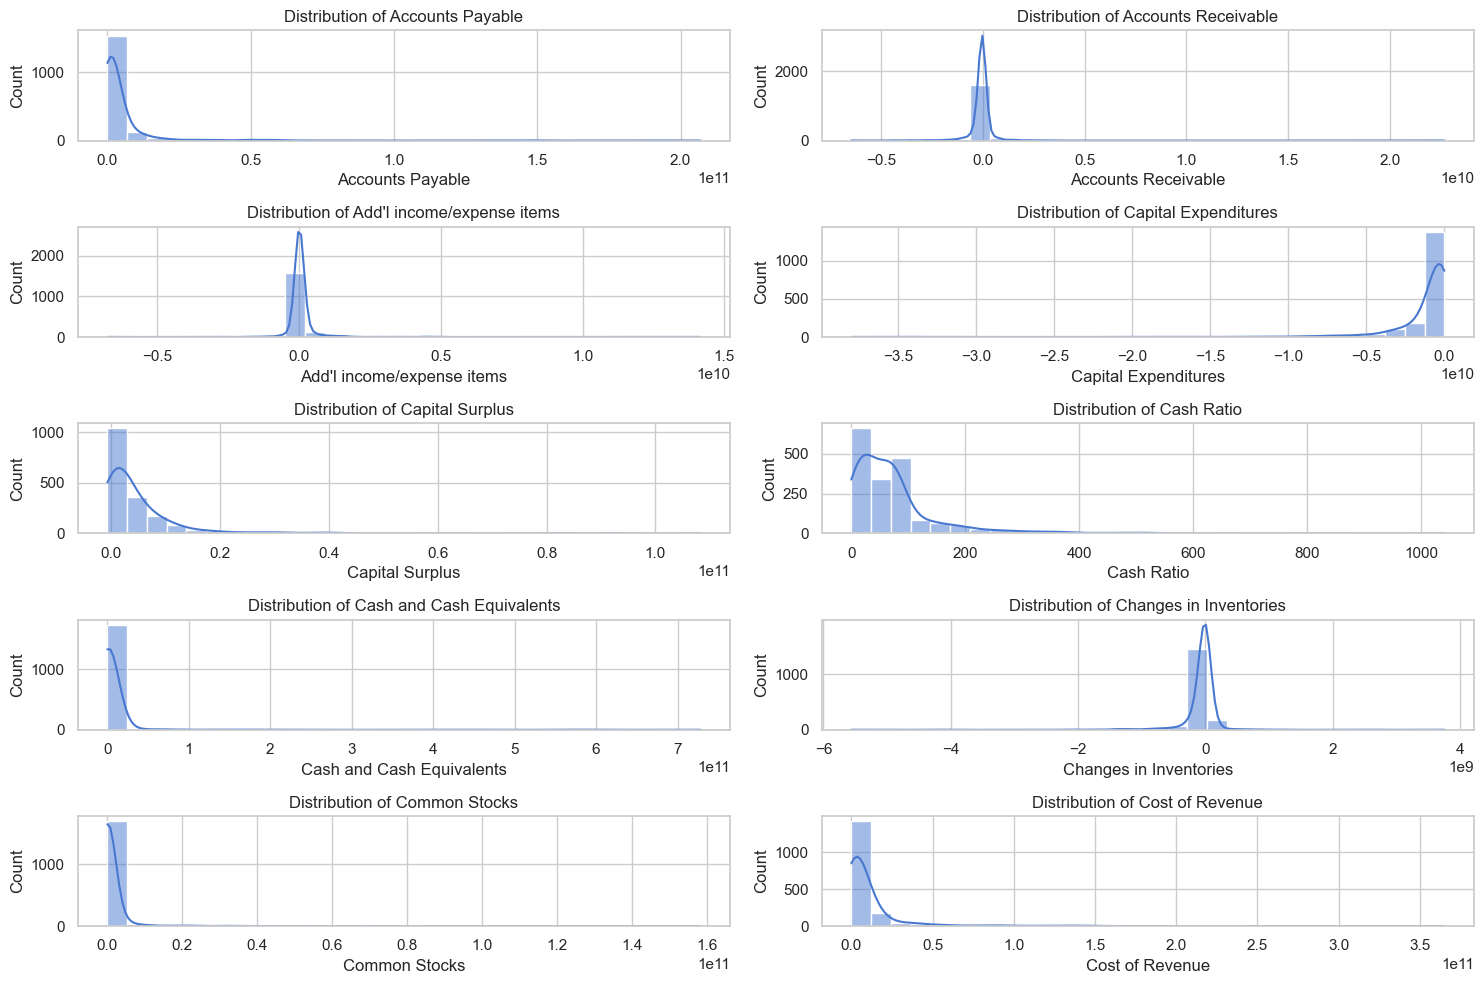

In [12]:
# Select numerical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_cols.remove('After Tax ROE')  # Exclude target variable

# Plot histograms for selected numerical features
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols[:10], 1):  # Plot first 10 for brevity
    plt.subplot(5, 2, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

### Distribution of the Target Variable (After Tax ROE)
Understanding the distribution of ROE is crucial for modeling.

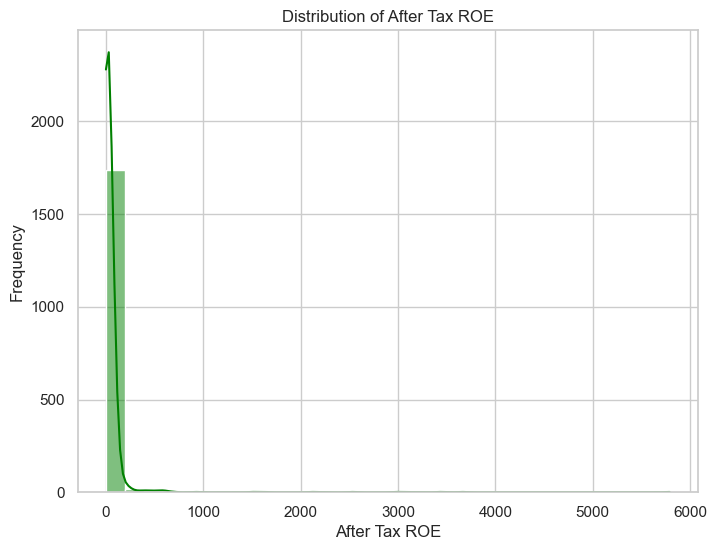

In [13]:
plt.figure(figsize=(8, 6))
sns.histplot(df['After Tax ROE'], kde=True, bins=30, color='green')
plt.title('Distribution of After Tax ROE')
plt.xlabel('After Tax ROE')
plt.ylabel('Frequency')
plt.show()

### Box Plots to Identify Outliers
Visualizing potential outliers in key features.

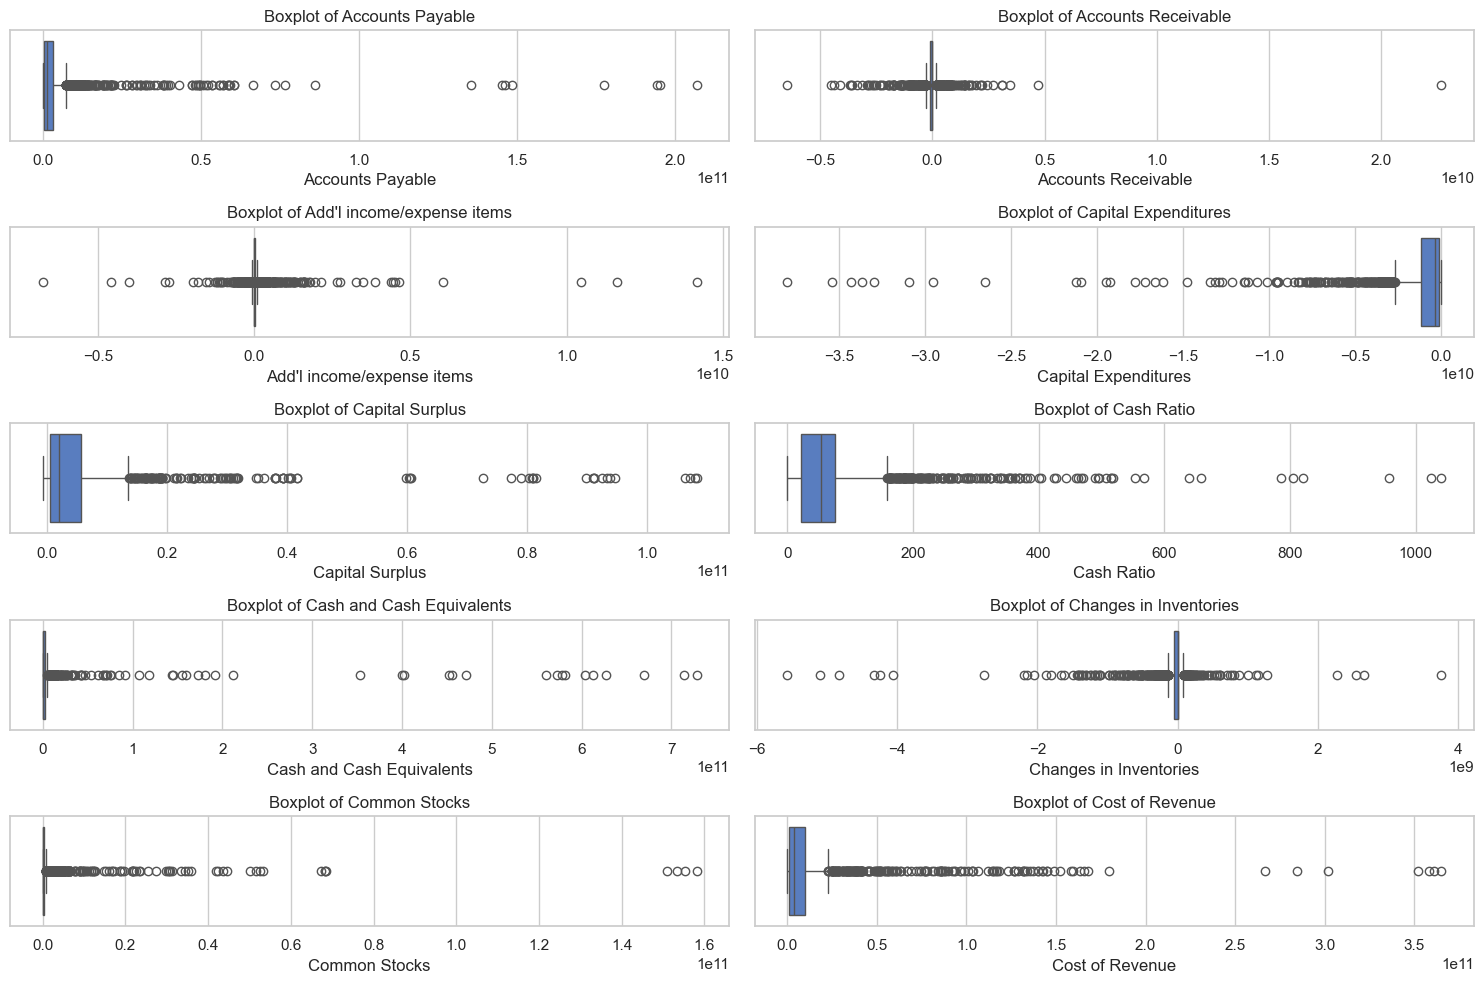

In [14]:
# Plot boxplots for selected numerical features
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols[:10], 1):  # Plot first 10 for brevity
    plt.subplot(5, 2, i)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

### Correlation Heatmap
Visualizing the correlation between features and ROE.

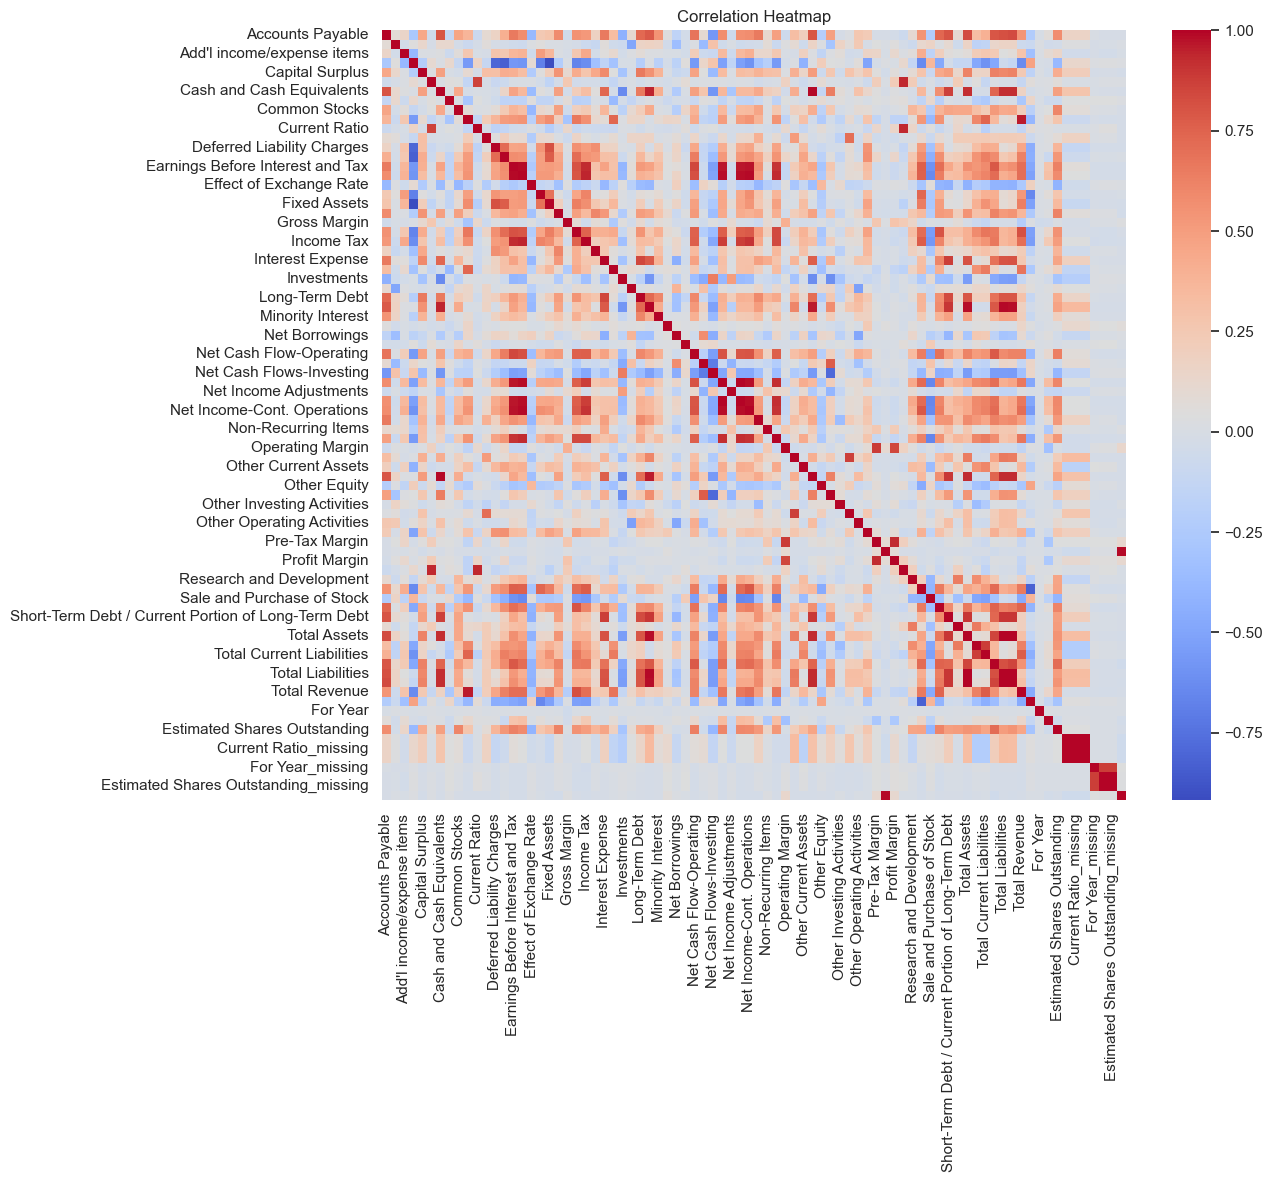

In [15]:
# Compute the correlation matrix
corr_matrix = df[numerical_cols + ['After Tax ROE']].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

### Pairplot for Selected Features
A pairplot to visualize relationships between a subset of features.

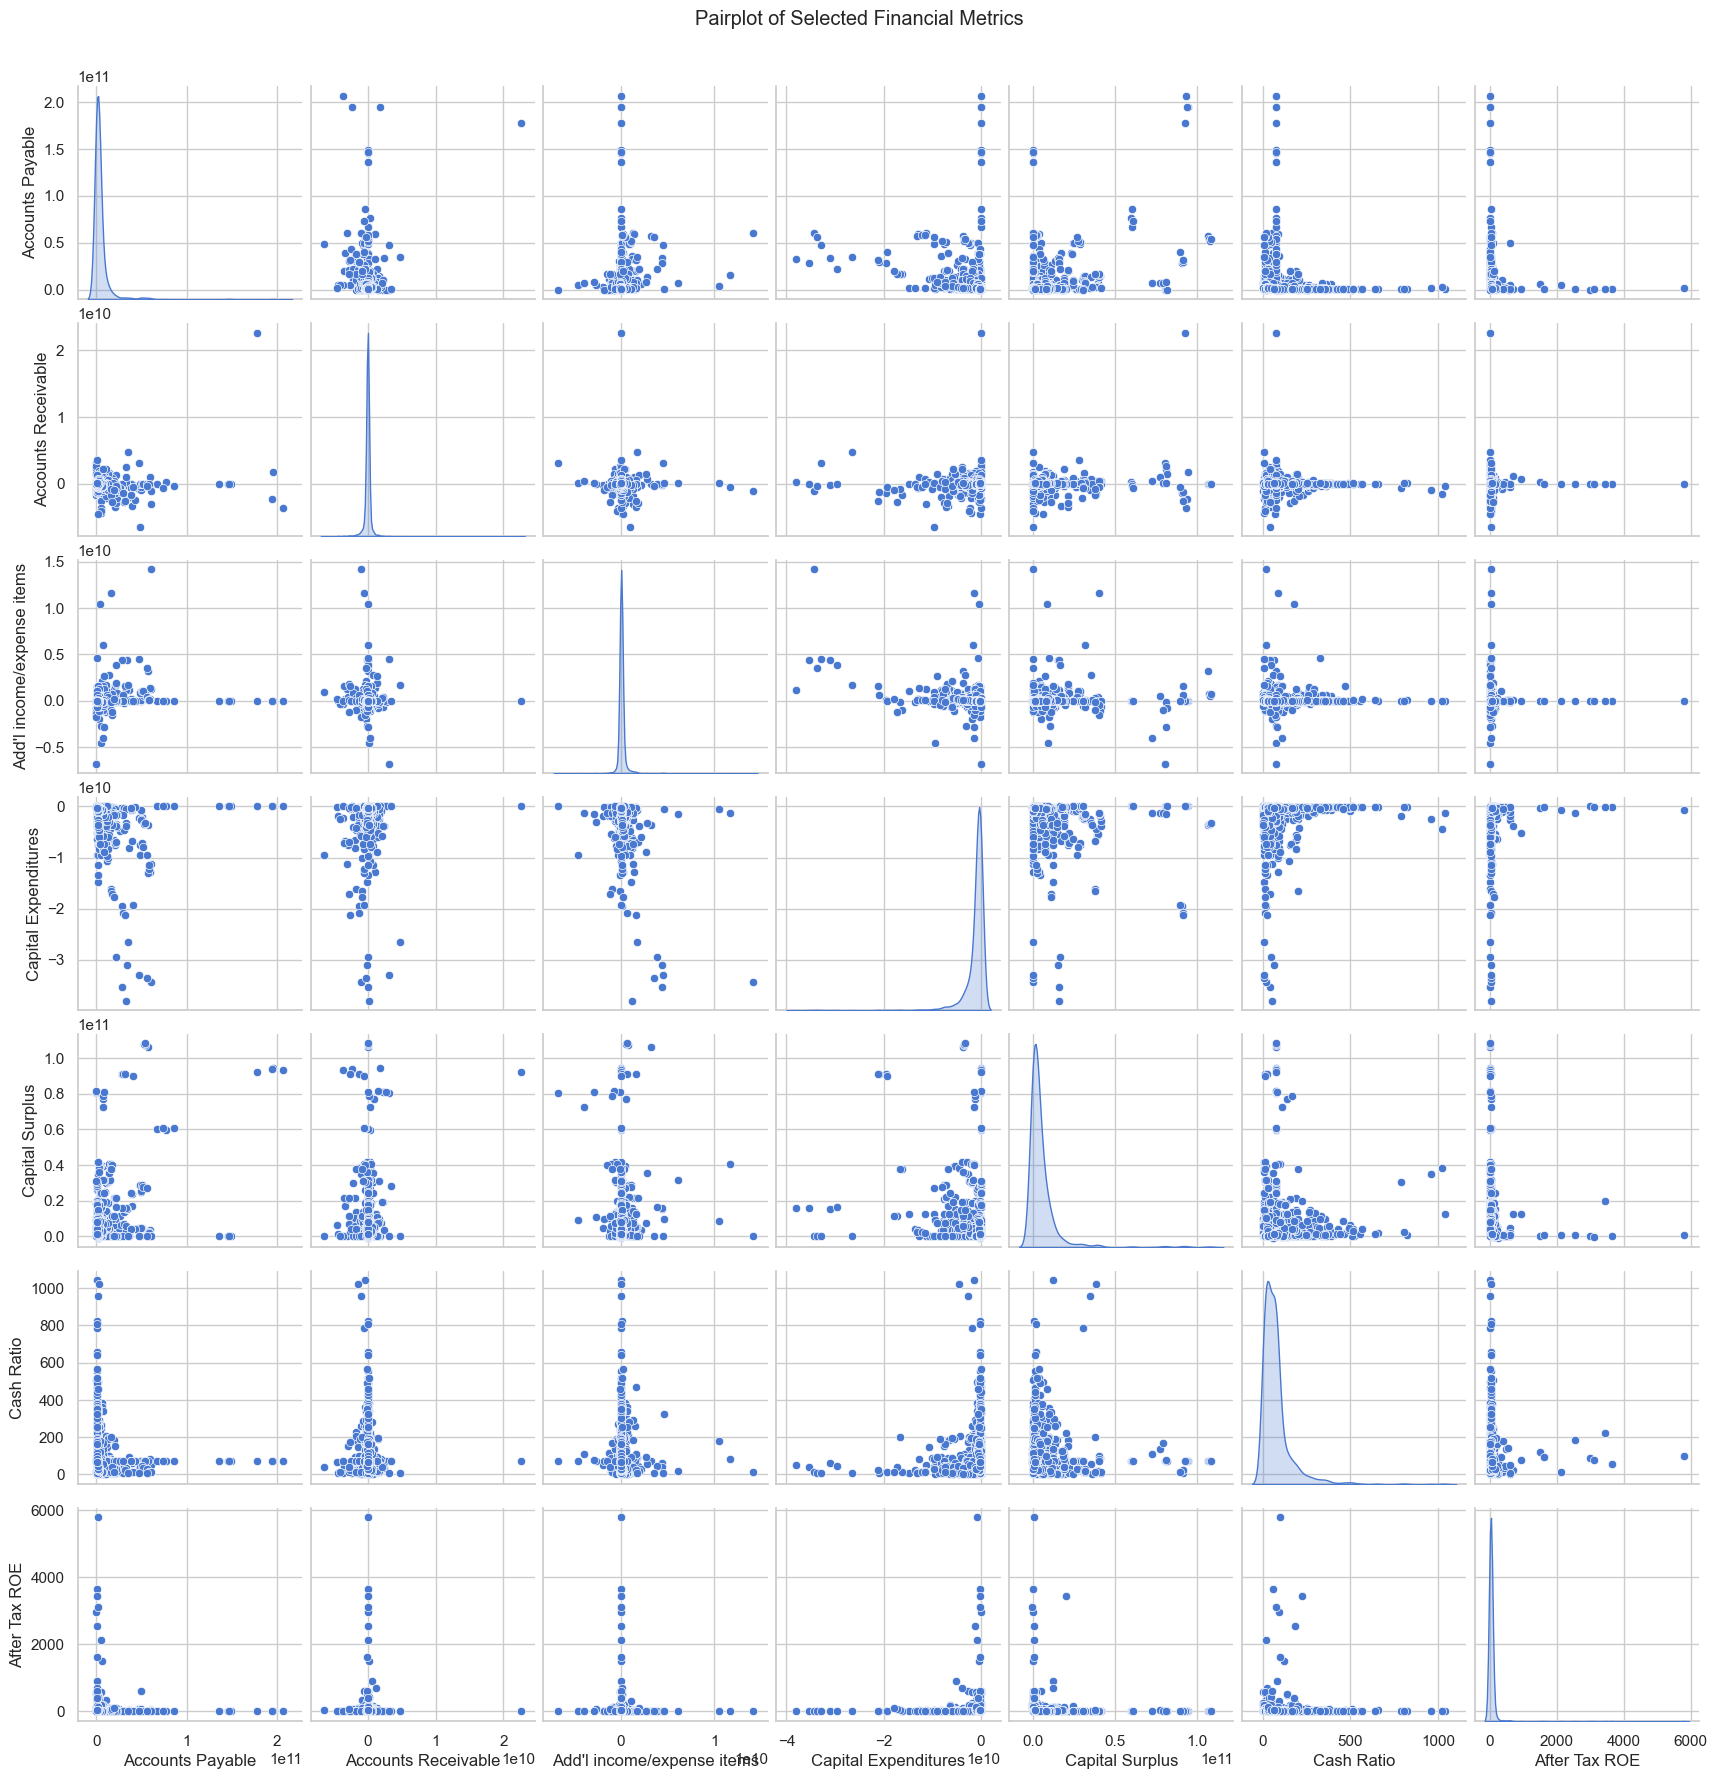

In [16]:
# Select a subset of features for pairplot
selected_features = ['Accounts Payable', 'Accounts Receivable', 
                     "Add'l income/expense items", 'Capital Expenditures', 
                     'Capital Surplus', 'Cash Ratio', 'After Tax ROE']

sns.pairplot(df[selected_features].dropna(), diag_kind='kde')
plt.suptitle('Pairplot of Selected Financial Metrics', y=1.02)
plt.show()

## Feature Engineering
We'll create additional features that might capture more information, such as financial ratios.

In [17]:

# Create financial ratios
df['Current Ratio'] = df['Total Current Assets'] / df['Total Current Liabilities']
df['Debt to Equity'] = df['Total Liabilities'] / df['Total Equity']
df['Net Profit Margin'] = df['Net Income'] / df['Total Revenue']

# Handle infinite values resulting from division by zero
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Impute newly created ratio columns if any missing values exist
ratio_cols = ['Current Ratio', 'Debt to Equity', 'Net Profit Margin']
imputer.fit(df[ratio_cols])
df[ratio_cols] = imputer.transform(df[ratio_cols])

print("\nFeature engineering completed with new financial ratios.")
    


Feature engineering completed with new financial ratios.


### Visualizing New Financial Ratios
Understanding the distribution of newly created features.

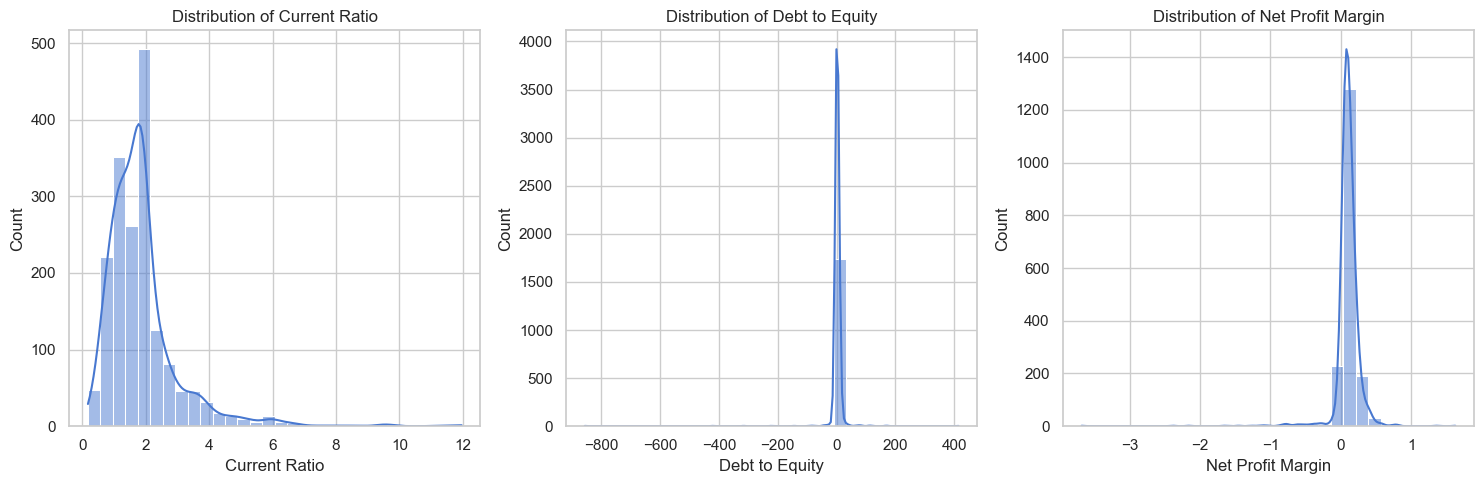

In [18]:
# Plot histograms for new financial ratios
plt.figure(figsize=(15, 5))
for i, col in enumerate(ratio_cols, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

## Encoding Categorical Variables
We'll encode categorical variables using One-Hot Encoding.

In [20]:
# Identify categorical columns
categorical_cols = ['Ticker Symbol']  # 'For Year' has been used to extract 'Year'

# Initialize OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Fit and transform the categorical columns
encoded_features = encoder.fit_transform(df[categorical_cols])

# Get the new column names from the encoder
encoded_cols = encoder.get_feature_names_out(categorical_cols)

# Create a DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoded_cols, index=df.index)

# Concatenate the encoded columns with the original dataframe
df = pd.concat([df, encoded_df], axis=1)

# Drop the original categorical columns
df.drop(columns=categorical_cols, inplace=True)

print("\nCategorical variables encoded using One-Hot Encoding.")



Categorical variables encoded using One-Hot Encoding.


## Scaling Features
We'll scale numerical features to ensure that they contribute equally to the model performance.

In [21]:
# Define numerical features to scale
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_cols.remove('After Tax ROE')  # Exclude target variable

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the numerical features
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

print("\nNumerical features scaled using StandardScaler.")


Numerical features scaled using StandardScaler.


## Feature Selection and Dimensionality Reduction
We'll select the most relevant features using correlation analysis and regularization techniques. `Pre-Tax ROE` is excluded to prevent data leakage

### Correlation Analysis to Select Top Features
Identify features that are most correlated with ROE.

In [28]:
# Define target and features, excluding 'Pre-Tax ROE'
X = df.drop(columns=['After Tax ROE', 'Pre-Tax ROE'])  # Exclude 'Pre-Tax ROE'
y = df['After Tax ROE']

# Compute correlation matrix
corr_matrix = df.corr()

# Get absolute correlation of features with target variable, excluding 'After Tax ROE' and 'Pre-Tax ROE'
correlation_with_roe = corr_matrix['After Tax ROE'].abs().sort_values(ascending=False)
correlation_with_roe = correlation_with_roe.drop(['After Tax ROE', 'Pre-Tax ROE'])  # Drop target and 'Pre-Tax ROE'

# Display top 10 correlated features
top_features = correlation_with_roe.head(10).index.tolist()  # Top 10 features excluding 'Pre-Tax ROE'
print("\nTop 10 features based on correlation with After Tax ROE:")
print(top_features)


Top 10 features based on correlation with After Tax ROE:
['Ticker Symbol_LB', 'Ticker Symbol_ALLE', 'Ticker Symbol_COTY', 'Ticker Symbol_VRSN', 'Ticker Symbol_MJN', 'Ticker Symbol_WYNN', 'Ticker Symbol_KMB', 'Operating Margin', 'Profit Margin', 'Pre-Tax Margin']


### Visualizing Correlation with ROE
Bar plot of top correlated features.

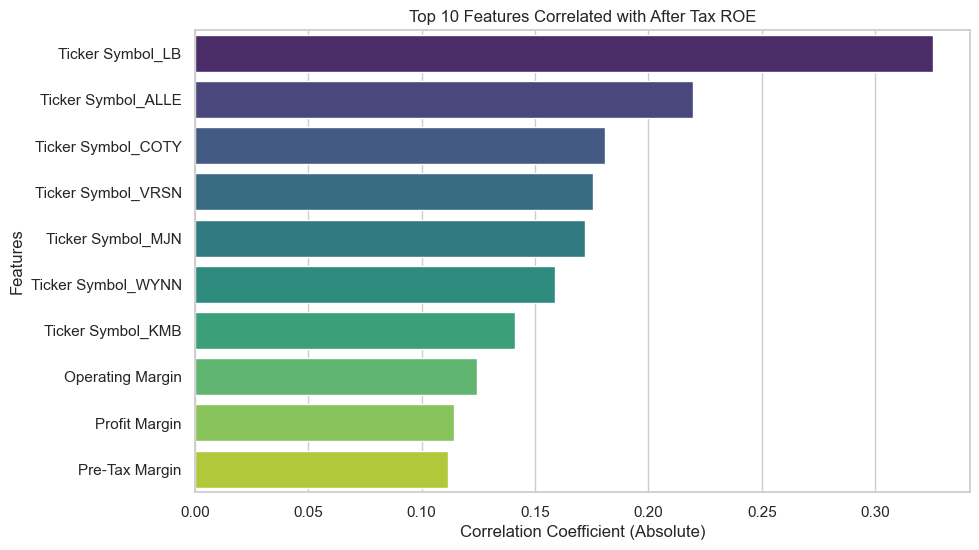

In [29]:
# Plot correlation of top features with ROE
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_roe[top_features], y=top_features, palette='viridis')
plt.title('Top 10 Features Correlated with After Tax ROE')
plt.xlabel('Correlation Coefficient (Absolute)')
plt.ylabel('Features')
plt.show()

### Feature Importance using Lasso Regression
Using Lasso to perform feature selection.

In [30]:
# Feature Importance using Lasso Regression, excluding 'Pre-Tax ROE'
selected_features = top_features.copy()

# Initialize Lasso regression with a small alpha for regularization
lasso = Lasso(alpha=0.01)

# Fit Lasso model on the top correlated features
lasso.fit(X[top_features], y)

# Get coefficients from the Lasso model
coef = pd.Series(lasso.coef_, index=top_features)

# Select features with non-zero coefficients
selected_features = coef[coef != 0].index.tolist()
print("\nFeatures selected by Lasso Regression:")
print(selected_features)


Features selected by Lasso Regression:
['Ticker Symbol_LB', 'Ticker Symbol_ALLE', 'Ticker Symbol_COTY', 'Ticker Symbol_VRSN', 'Ticker Symbol_MJN', 'Ticker Symbol_WYNN', 'Ticker Symbol_KMB', 'Operating Margin', 'Profit Margin', 'Pre-Tax Margin']


### Visualizing Lasso Coefficients
Bar plot of Lasso coefficients.

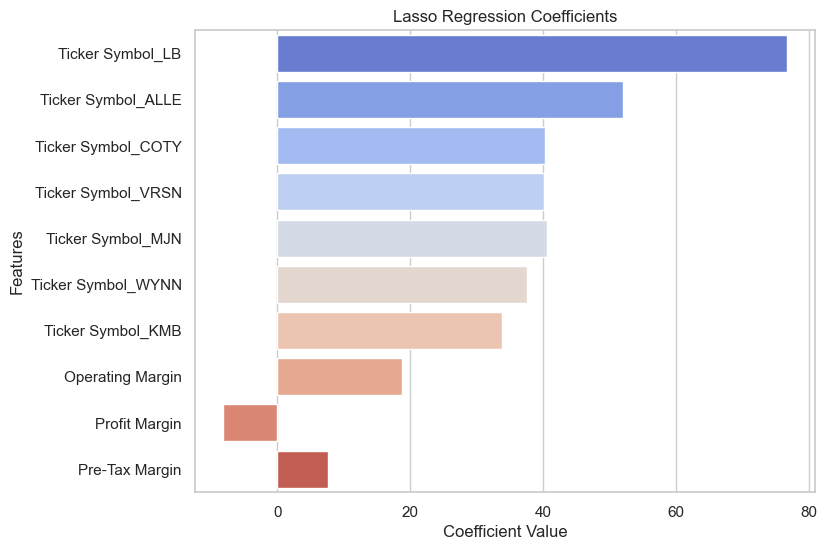

In [31]:
# Plot Lasso coefficients for the selected features
plt.figure(figsize=(8, 6))
sns.barplot(x=coef[selected_features], y=selected_features, palette='coolwarm')
plt.title('Lasso Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()

## Model Training and Hyperparameter Tuning
We'll train multiple regression models and perform hyperparameter tuning to find the best model.

In [32]:
# Define the final feature set
X_final = X[selected_features]

# Split the training data further into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_final, y, test_size=0.2, shuffle=False)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

# Define hyperparameters for tuning
param_grids = {
    'Ridge Regression': {'alpha': [0.1, 1, 10, 100]},
    'Lasso Regression': {'alpha': [0.01, 0.1, 1, 10]},
    'Random Forest': {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]},
    'Gradient Boosting': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
}

# Dictionary to store best models
best_models = {}

# Train and tune models
for name, model in models.items():
    print(f"\nTraining {name}...")
    if name in param_grids:
        grid = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid.fit(X_train, y_train)
        best_models[name] = grid.best_estimator_
        print(f"Best parameters for {name}: {grid.best_params_}")
    else:
        model.fit(X_train, y_train)
        best_models[name] = model
        print(f"{name} trained without hyperparameter tuning.")



Training Linear Regression...
Linear Regression trained without hyperparameter tuning.

Training Ridge Regression...
Best parameters for Ridge Regression: {'alpha': 100}

Training Lasso Regression...
Best parameters for Lasso Regression: {'alpha': 1}

Training Random Forest...
Best parameters for Random Forest: {'max_depth': 10, 'n_estimators': 100}

Training Gradient Boosting...
Best parameters for Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}


## Model Evaluation and Explainability
We'll evaluate the performance of each model and interpret feature importance.


Model Evaluation Metrics:
               Model        MAE           MSE        RMSE        R2
0  Linear Regression  37.730892  51733.138280  227.449199  0.010626
1   Ridge Regression  38.003752  51752.132692  227.490951  0.010262
2   Lasso Regression  37.509111  51743.295654  227.471527  0.010431
3      Random Forest  41.923132  54049.113500  232.484652 -0.033666
4  Gradient Boosting  44.079454  54234.600873  232.883234 -0.037214


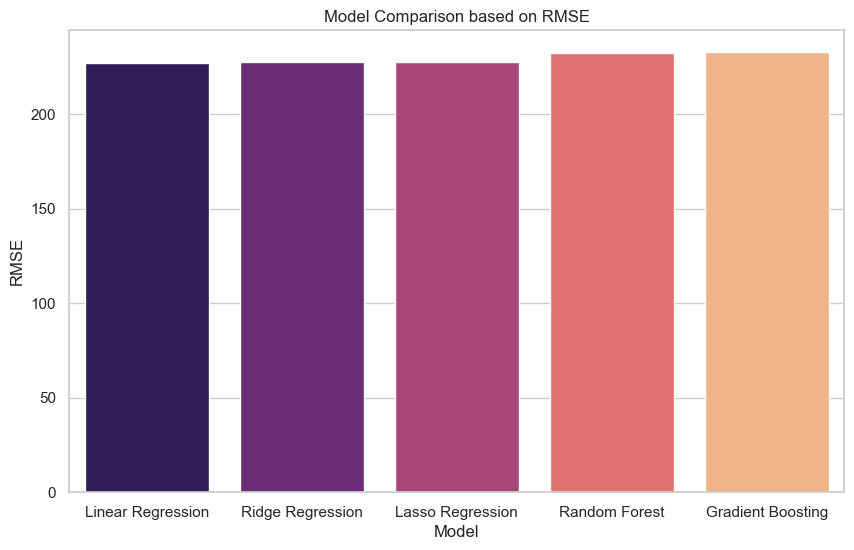

In [34]:
# Initialize a DataFrame to store evaluation metrics
evaluation_metrics = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2'])

# Evaluate each model
rows = []  # Use a list to store each row as a dictionary
for name, model in best_models.items():
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred)
    rows.append({
        'Model': name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    })

# Convert the rows list into a DataFrame
evaluation_metrics = pd.DataFrame(rows)

print("\nModel Evaluation Metrics:")
print(evaluation_metrics)

# Plot evaluation metrics
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='RMSE', data=evaluation_metrics, palette='magma')
plt.title('Model Comparison based on RMSE')
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.show()

### Feature Importance for Tree-Based Models
Visualizing feature importance for Random Forest and Gradient Boosting models.

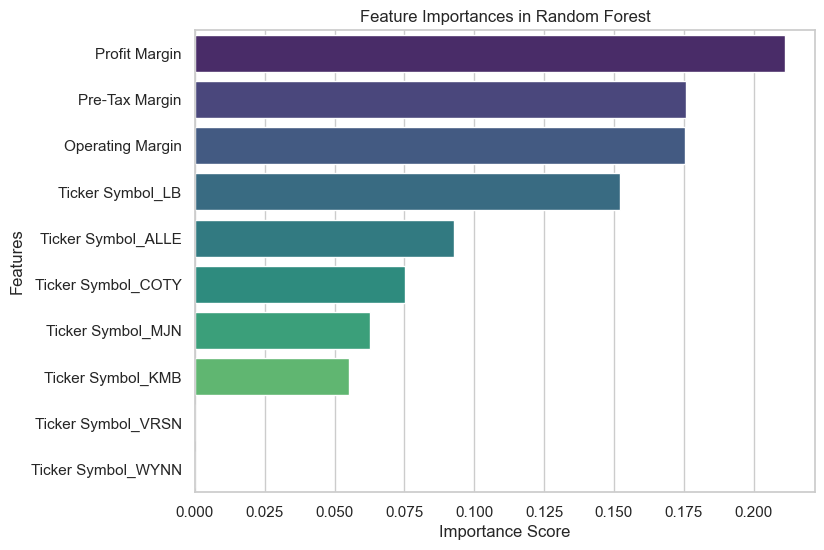

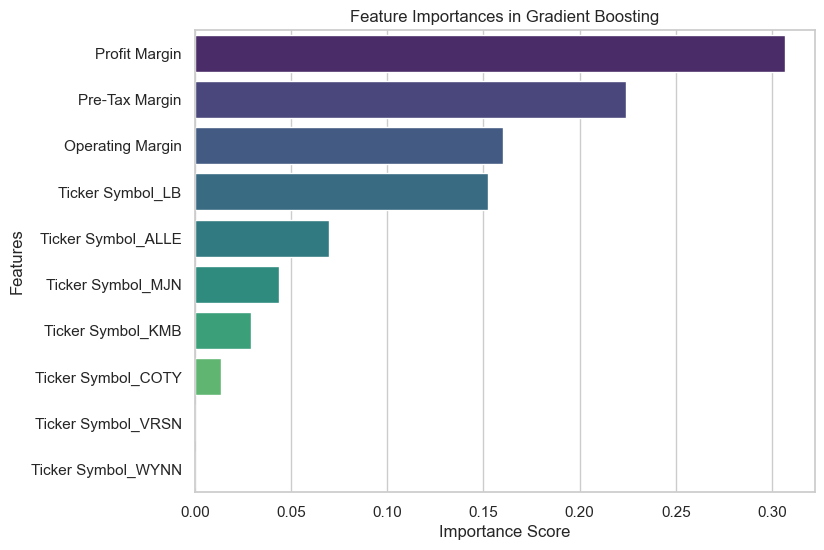

In [35]:
# Feature Importance for Random Forest and Gradient Boosting
for name in ['Random Forest', 'Gradient Boosting']:
    model = best_models[name]
    if hasattr(model, 'feature_importances_'):
        importances = pd.Series(model.feature_importances_, index=X_final.columns)
        importances = importances.sort_values(ascending=False)
        
        plt.figure(figsize=(8, 6))
        sns.barplot(x=importances.values, y=importances.index, palette='viridis')
        plt.title(f'Feature Importances in {name}')
        plt.xlabel('Importance Score')
        plt.ylabel('Features')
        plt.show()

### Residual Analysis
Checking residuals to validate model assumptions.

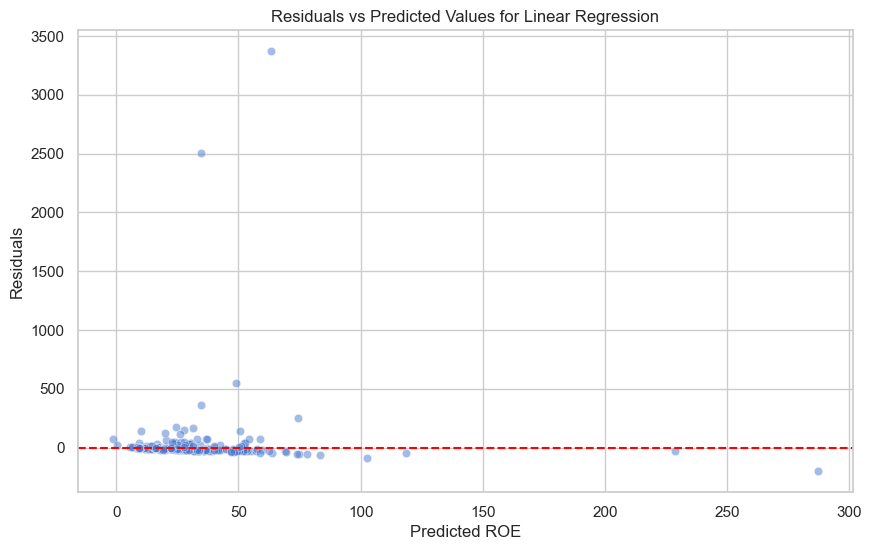

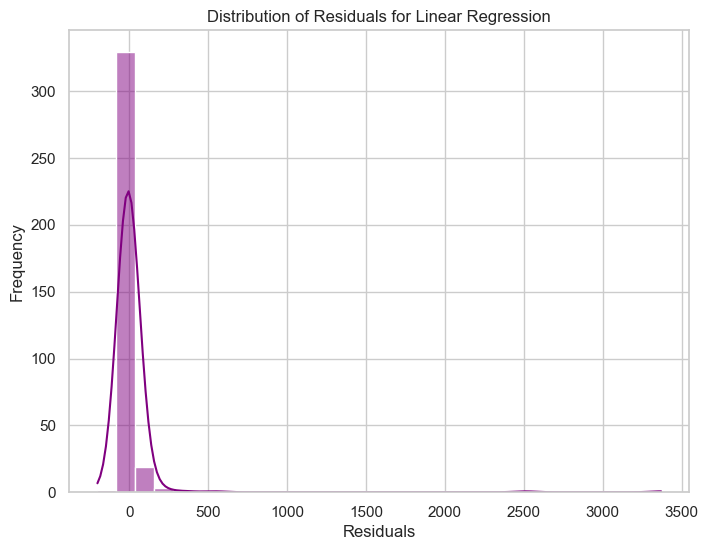

In [36]:
# Plot residuals for the best model based on R2
best_model_name = evaluation_metrics.sort_values(by='R2', ascending=False).iloc[0]['Model']
best_model = best_models[best_model_name]
y_pred_best = best_model.predict(X_val)
residuals = y_val - y_pred_best

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_best, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title(f'Residuals vs Predicted Values for {best_model_name}')
plt.xlabel('Predicted ROE')
plt.ylabel('Residuals')
plt.show()

# Distribution of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='purple')
plt.title(f'Distribution of Residuals for {best_model_name}')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

## Model Validation
We'll perform cross-validation to ensure that our models generalize well to unseen data.


Cross-validating Linear Regression...

Cross-validating Ridge Regression...

Cross-validating Lasso Regression...

Cross-validating Random Forest...

Cross-validating Gradient Boosting...

Cross-Validation Metrics:
               Model        MAE           MSE        RMSE        R2
0  Linear Regression  38.441151  53823.653550  196.490715  0.016848
1   Ridge Regression  38.186047  53881.138807  196.553036  0.019018
2   Lasso Regression  37.966267  53827.798019  196.411696  0.020381
3      Random Forest  41.419219  55690.784810  203.330301 -0.150340
4  Gradient Boosting  41.013626  55031.912145  199.196626 -0.008631


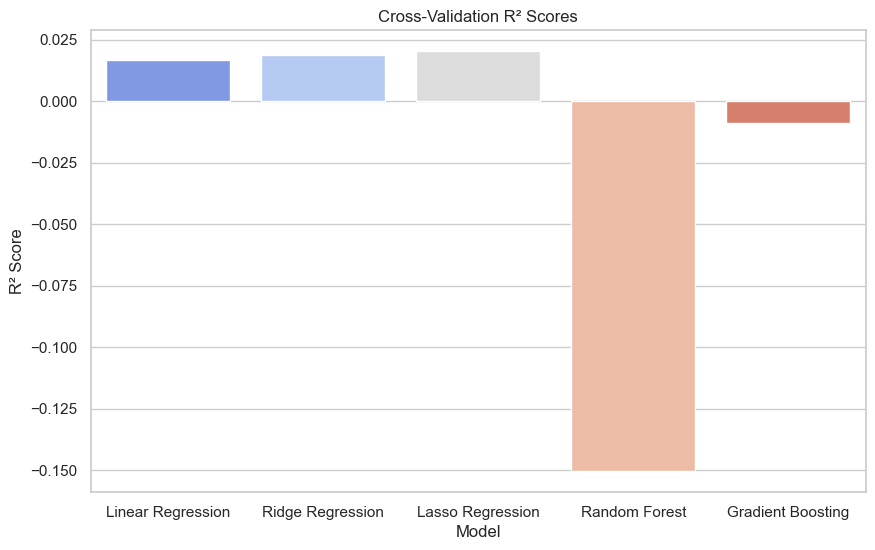

In [39]:
# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Function to perform cross-validation and return average metrics
def cross_validate_model(model, X, y, splits):
    mae_scores = []
    mse_scores = []
    r2_scores = []
    for train_index, test_index in splits.split(X):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_test_cv)
        mae_scores.append(mean_absolute_error(y_test_cv, y_pred_cv))
        mse_scores.append(mean_squared_error(y_test_cv, y_pred_cv))
        r2_scores.append(r2_score(y_test_cv, y_pred_cv))
    return {
        'MAE': np.mean(mae_scores),
        'MSE': np.mean(mse_scores),
        'RMSE': np.mean(np.sqrt(mse_scores)),
        'R2': np.mean(r2_scores)
    }

# Perform cross-validation for each model
cv_metrics = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2'])

for name, model in best_models.items():
    print(f"\nCross-validating {name}...")
    metrics = cross_validate_model(model, X_final, y, tscv)
    # Create a DataFrame for the current model's metrics
    metrics_df = pd.DataFrame([{
        'Model': name,
        'MAE': metrics['MAE'],
        'MSE': metrics['MSE'],
        'RMSE': metrics['RMSE'],
        'R2': metrics['R2']
    }])
    # Concatenate the metrics_df with cv_metrics
    cv_metrics = pd.concat([cv_metrics, metrics_df], ignore_index=True)

print("\nCross-Validation Metrics:")
print(cv_metrics)

# Plot cross-validation R2 scores
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='R2', data=cv_metrics, palette='coolwarm')
plt.title('Cross-Validation R² Scores')
plt.ylabel('R² Score')
plt.xlabel('Model')
plt.show()

## Model Explainability
We'll use SHAP values to interpret the contribution of each feature to the model's predictions.


Best Model: Linear Regression


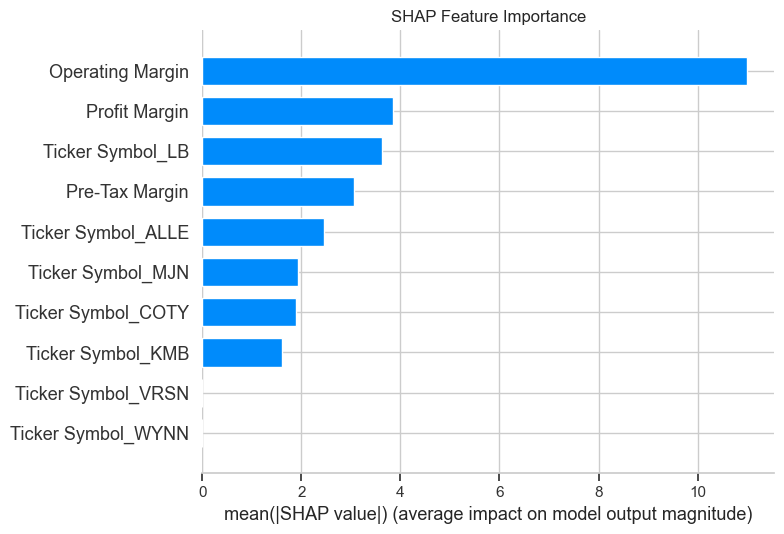

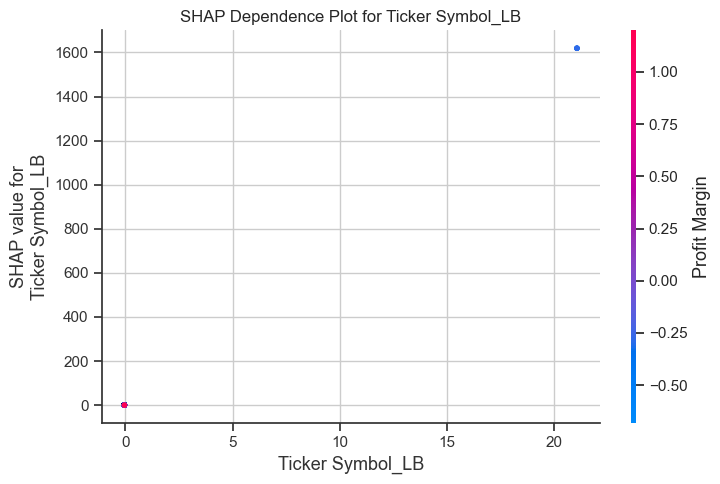

In [40]:
# Select the best model based on R2 score
best_model_name = evaluation_metrics.sort_values(by='R2', ascending=False).iloc[0]['Model']
best_model = best_models[best_model_name]
print(f"\nBest Model: {best_model_name}")

# Initialize SHAP explainer
explainer = shap.Explainer(best_model, X_final)
shap_values = explainer(X_final)

# Summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_final, plot_type="bar", show=False)
plt.title('SHAP Feature Importance')
plt.tight_layout()
plt.show()

# Dependence plot for the top feature
top_feature = selected_features[0]
shap.dependence_plot(top_feature, shap_values.values, X_final, show=False)
plt.title(f'SHAP Dependence Plot for {top_feature}')
plt.tight_layout()
plt.show()